In [1]:
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dask import bag
from tqdm import tqdm
from PIL import Image, ImageDraw
import nbimporter
from DataParserForCNN import drawing_to_image, read_class

% matplotlib inline

Importing Jupyter notebook from DataParserForCNN.ipynb


Using TensorFlow backend.


In [2]:
def entropy_it(x):
    counts = np.bincount(x)
    p = counts[counts > 0] / float(len(x))
    # compute Shannon entropy in bits
    return -np.sum(p * np.log2(p))

def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            draw.line([stroke[0][i], stroke[1][i], stroke[0][i+1], stroke[1][i+1]], fill=0, width=5)
    image = np.array(image)
    return entropy_it(image.flatten()), image

def plot_it(entropy, images, indices, n=5):
    fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(12, 10))
    for i, j in enumerate(indices[0][:n*n]):
        ax = axs[i // n, i % n]
        ax.set_title("%.4f" % entropy[j])
        ax.imshow(images[j], cmap="gray")
        ax.set_yticks([])
        ax.set_xticks([])
        plt.setp(ax.spines.values(), color="red")
    plt.subplots_adjust(bottom=-0.2)
    plt.show()

In [4]:
reader = pd.read_csv('/Volumes/JS/QuickDraw/train_simplified/star.csv', index_col=['key_id'], chunksize=1024)

data = []
for chunk in tqdm(reader):
    entropybag = bag.from_sequence(chunk.drawing.values).map(draw_it)
    data.extend(entropybag.compute()) # PARALLELIZE

entropy, images = zip(*data)

135it [02:27,  1.09s/it]


In [5]:
exclude= 1
lower = np.percentile(entropy, exclude)        # 0%~1% exclude the
upper = np.percentile(entropy, 100 - exclude)  # 99%~100%
print(np.min(entropy), np.max(entropy))
print(lower, upper)

0.0025374024260430028 0.9990242991302142
0.25751550265969386 0.5118598092447499


In [29]:
df = pd.read_csv('/Volumes/JS/QuickDraw/train_simplified/star.csv')
print(len(df))
lower_array = np.where(entropy < lower)[0]
upper_array = np.where(entropy > upper)[0]

137619


In [38]:
print(lower_array)
print(lower_array.shape)
print(upper_array.shape)

[    33    498    503 ... 137297 137396 137471]
(1375,)
(1376,)


In [37]:
total = np.append(lower_array, upper_array)
print(total)
print(total.shape)

[    33    498    503 ... 137544 137588 137610]
(2751,)


In [33]:
df = df.drop(df.index[total])

In [34]:
len(df)

134868

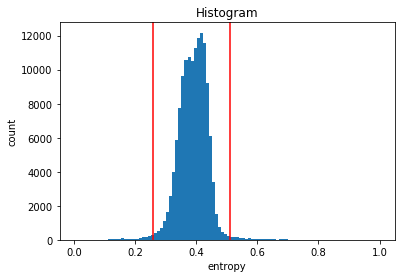

In [6]:
plt.title('Histogram')
plt.xlabel('entropy')
plt.ylabel('count')
plt.hist(entropy, bins=100)
plt.axvline(x=lower, color='r')
plt.axvline(x=upper, color='r')

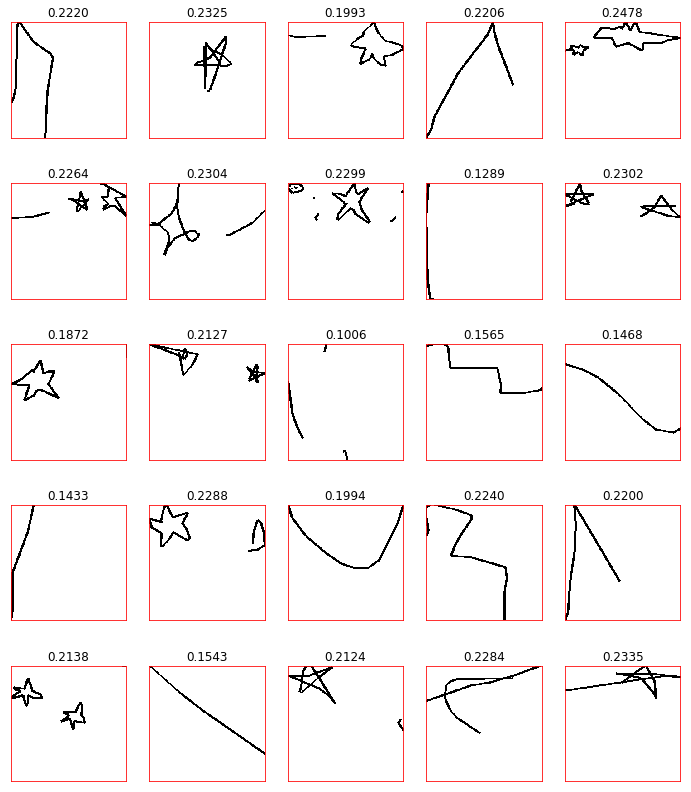

In [10]:
plot_it(entropy, images, np.where(entropy < lower))

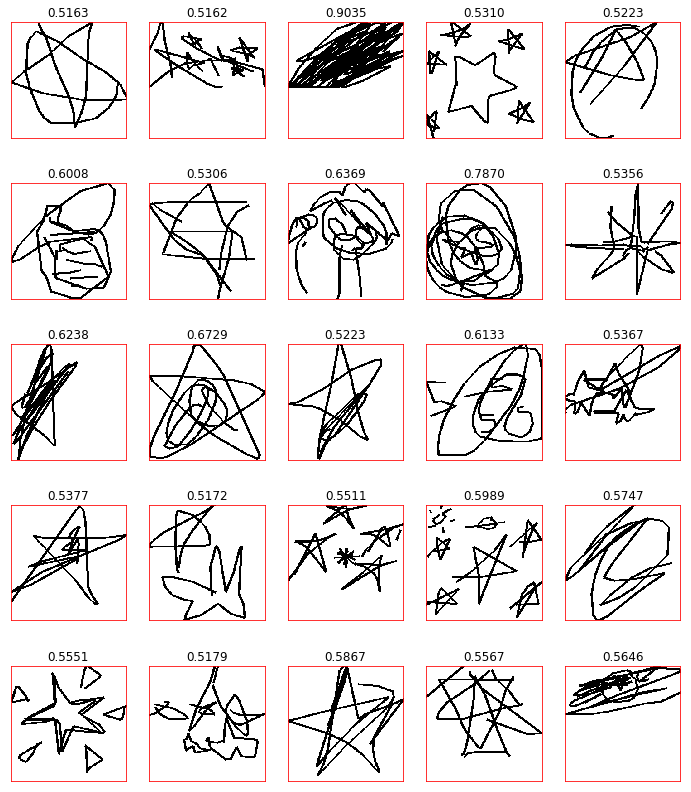

In [20]:
plot_it(entropy, images, np.where(entropy > upper))

In [5]:
def compute_entropy(name, exclude=1):
    chunks = pd.read_csv('/Volumes/JS/QuickDraw/train_simplified/%s.csv' % name, 
                         index_col=['key_id'], chunksize=1024)
    data = []
    for chunk in tqdm(chunks):
        entropybag = bag.from_sequence(chunk.drawing.values).map(draw_it)
        data.extend(entropybag.compute()) # PARALLELIZE

    entropy, images = zip(*data)
    
#     exclude= 1
    lower = np.percentile(entropy, exclude)        # 0%~1% exclude the
    upper = np.percentile(entropy, 100 - exclude)  # 99%~100%
    print(lower, upper, '\n')
    
    plt.title('%s' % name)
    plt.xlabel('entropy')
    plt.ylabel('count')
    plt.hist(entropy, bins=100)
    plt.axvline(x=lower, color='r')
    plt.axvline(x=upper, color='r')
    
    lower_array = np.where(entropy < lower)[0]
    upper_array = np.where(entropy > upper)[0]
    
    return lower_array, upper_array

In [6]:
def noise_removal_dataset(base_path='/Volumes/JS/QuickDraw/'):
    all_npy_path = base_path + 'noise_removal/train_simplified'
    train_npy_path = base_path + 'noise_removal/small_train_set'
    valid_npy_path = base_path + 'noise_removal/small_valid_set'

    for i, name in enumerate(class_array):
        if i>64:
            print(name)
            name = name.replace('_', ' ')
            lower_array, upper_array = compute_entropy(name)
            to_drop = np.append(lower_array, upper_array)
            df = pd.read_csv(base_path + 'train_simplified/%s.csv' % name)
            print(len(df))
            df = df.drop(df.index[to_drop])
            print(len(df))
            key_id = df['key_id'].values.astype(np.int64)
            np.random.shuffle(key_id)

            n = len(key_id)
            n_valid = NUM_VALID
            n_train = n - n_valid

            np.save(all_npy_path + '/%s.npy' % name, key_id)
            np.save(train_npy_path + '/%s.npy' % name, key_id[:n_train])
            np.save(valid_npy_path + '/%s.npy' % name, key_id[n_train:])
    print('Finish dataset split.')

castle


120it [02:21,  1.18s/it]


0.23009523605067198 0.568478956411199 



0it [00:00, ?it/s]

122534
120086
cat


121it [02:20,  1.16s/it]


0.2719760060675974 0.570773341437052 



0it [00:00, ?it/s]

123202
120736
ceiling_fan


113it [02:10,  1.16s/it]


0.2205806485380993 0.6005746366158959 

115413
113103
cell_phone


119it [02:17,  1.16s/it]


0.2904337225445982 0.5865900947906048 



0it [00:00, ?it/s]

121130
118707
cello


147it [02:51,  1.17s/it]


0.22666876419226084 0.7489463748792626 



0it [00:00, ?it/s]

149725
146729
chair


218it [04:39,  1.28s/it]


0.18542987838034564 0.5552694441470586 

222706
218252


0it [00:00, ?it/s]

chandelier


164it [03:42,  1.36s/it]


0.21117403733348059 0.7189518504468855 

167502
164151
church


161it [03:34,  1.33s/it]


0.22362024198031616 0.5874252274526433 

164225
160946
circle


120it [02:37,  1.32s/it]


0.22735276286086892 0.48593045177826577 

122876
120418
clarinet


124it [02:48,  1.36s/it]


0.18768391045164282 0.5778620348321756 



0it [00:00, ?it/s]

126214
123689
clock


118it [02:33,  1.30s/it]


0.30056531152703253 0.5037695428845951 



0it [00:00, ?it/s]

120536
118125
cloud


118it [02:29,  1.27s/it]


0.2073815635682353 0.5048850093071975 



0it [00:00, ?it/s]

120265
117863
coffee_cup


180it [03:38,  1.22s/it]


0.2709322125327961 0.6108932114909236 

183432
179765


0it [00:00, ?it/s]

compass


125it [02:29,  1.20s/it]


0.29375358479172603 0.5704022141361619 



0it [00:00, ?it/s]

127609
125057
computer


121it [02:30,  1.24s/it]


0.29890705453757 0.6436233966255769 



0it [00:00, ?it/s]

123885
121407
cookie


129it [02:45,  1.28s/it]


0.2560835017627225 0.5794619682513426 



0it [00:00, ?it/s]

131353
128727
cooler


266it [05:31,  1.25s/it]


0.26347772163937994 0.6999921731684617 

271444
266015


0it [00:00, ?it/s]

couch


117it [02:16,  1.17s/it]


0.26884501601719357 0.5899541646251835 

119662
117269


0it [00:00, ?it/s]

cow


121it [02:28,  1.23s/it]


0.28446222485036426 0.6417917163980117 



0it [00:00, ?it/s]

123083
120622
crab


124it [02:35,  1.25s/it]


0.25971041598923367 0.5853550425917653 

126930
124392
crayon


127it [02:33,  1.21s/it]


0.1789212159831219 0.5772996951929561 



0it [00:00, ?it/s]

129953
127356
crocodile


125it [02:33,  1.22s/it]


0.19796966415784023 0.5634782776959041 

127932
125374
crown


131it [02:34,  1.18s/it]


0.26576489719028623 0.5678260455362337 

134089
131409
cruise_ship


121it [02:24,  1.19s/it]


0.23408577198514607 0.5903547975024134 



0it [00:00, ?it/s]

123410
120939
cup


128it [02:34,  1.21s/it]


0.24791398693731592 0.5820511475232722 

130721
128105
diamond


129it [02:31,  1.18s/it]


0.20782907450842608 0.5647294707161028 



0it [00:00, ?it/s]

131587
128959
dishwasher


166it [03:21,  1.21s/it]


0.29234340377492296 0.7368526050020837 



0it [00:00, ?it/s]

169759
166365
diving_board


284it [05:41,  1.20s/it]


0.13957564582052528 0.5925286174756352 

290239
284457
dog


149it [03:02,  1.23s/it]


0.2546479046771961 0.580548914689799 



0it [00:00, ?it/s]

152159
149119
dolphin


119it [02:25,  1.23s/it]


0.19163261578947635 0.4829812653312802 



0it [00:00, ?it/s]

121613
119180
donut


138it [02:47,  1.22s/it]


0.30195634654192394 0.5695453035606217 

140751
137941
door


118it [02:23,  1.21s/it]


0.2465825347489084 0.503072098193494 

120230
117825
dragon


122it [02:34,  1.27s/it]


0.2458183035758431 0.6083104065123079 



0it [00:00, ?it/s]

124362
121878
dresser


121it [02:30,  1.24s/it]


0.29343338079611625 0.6643994994295624 



0it [00:00, ?it/s]

123395
120929
drill


134it [02:47,  1.25s/it]


0.2061115316027266 0.6371216727013812 



0it [00:00, ?it/s]

136786
134054
drums


135it [02:49,  1.25s/it]


0.2539630155927852 0.6320884251953691 



0it [00:00, ?it/s]

137299
134554
duck


133it [02:48,  1.27s/it]


0.2344406672306199 0.5415567400513555 



0it [00:00, ?it/s]

135480
132771
dumbbell


155it [03:15,  1.26s/it]


0.1763885078456159 0.7098685024898524 



0it [00:00, ?it/s]

157975
154818
ear


121it [02:45,  1.37s/it]


0.17797299937507788 0.5138877482036482 



0it [00:00, ?it/s]

122897
120445
elbow


124it [02:45,  1.33s/it]


0.16563495477038115 0.49529621966003035 



0it [00:00, ?it/s]

126253
123738
elephant


124it [02:48,  1.36s/it]


0.26790931659744127 0.5902523922021158 



0it [00:00, ?it/s]

126969
124431
envelope


132it [03:00,  1.37s/it]


0.2970099308542279 0.5092533084465256 

134863
132168
eraser


116it [02:28,  1.28s/it]


0.198454228164298 0.7082412948783716 

118339
115971


0it [00:00, ?it/s]

eye


123it [02:42,  1.32s/it]


0.24232227099864723 0.642545209639432 

125888
123370
eyeglasses


221it [04:43,  1.28s/it]


0.18969613805705235 0.5290836007448012 

225762
221259


0it [00:00, ?it/s]

face


158it [03:25,  1.30s/it]


0.28835125218461766 0.6528608278662263 

161666
158435
fan


133it [03:03,  1.38s/it]


0.2889046640239973 0.7200215437522908 

136158
133434


0it [00:00, ?it/s]

feather


118it [02:29,  1.27s/it]


0.16352708201781846 0.6431870748090778 



0it [00:00, ?it/s]

119910
117511
fence


127it [02:37,  1.24s/it]


0.16717465153810684 0.6447104685055784 



0it [00:00, ?it/s]

129426
126838
finger


165it [03:28,  1.27s/it]


0.191854157439796 0.5224601125941635 



0it [00:00, ?it/s]

167957
164603
fire_hydrant


135it [02:56,  1.31s/it]


0.23023825565103007 0.7012891469936517 



0it [00:00, ?it/s]

137242
134499
fireplace


152it [03:21,  1.32s/it]


0.29656402647651237 0.7583999053431647 



0it [00:00, ?it/s]

155570
152462
firetruck


216it [04:40,  1.30s/it]


0.2766725672556653 0.6261178078995994 

220695
216282


0it [00:00, ?it/s]

fish


132it [02:41,  1.22s/it]


0.24043935341499822 0.46372057857269605 



0it [00:00, ?it/s]

134150
131474
flamingo


122it [02:37,  1.29s/it]


0.2207669419303263 0.5049123991374538 



0it [00:00, ?it/s]

124569
122077
flashlight


235it [04:56,  1.26s/it]


0.22390966361024722 0.5087263200074984 

239763
234969


0it [00:00, ?it/s]

flip_flops


119it [02:32,  1.28s/it]


0.25505844372582837 0.5738534878800857 



0it [00:00, ?it/s]

121518
119087
floor_lamp


163it [03:15,  1.20s/it]


0.17797299937507788 0.5700525538135286 



0it [00:00, ?it/s]

166355
163030
flower


142it [02:55,  1.24s/it]


0.2519033923285142 0.5716251779281472 

144818
141921


0it [00:00, ?it/s]

flying_saucer


149it [03:06,  1.25s/it]


0.21316968979310463 0.6897464082782903 

151966
148928
foot


199it [04:02,  1.22s/it]


0.1886136374753408 0.5165812515017757 

203086
199027
fork


124it [02:28,  1.19s/it]


0.16798299426771818 0.48616484312628944 

126077
123557
frog


156it [03:12,  1.23s/it]


0.24990530039175907 0.6106644891978363 

159047
155873
frying_pan


121it [02:29,  1.24s/it]


0.193466627336233 0.5380495644733887 



0it [00:00, ?it/s]

123824
121347
garden


155it [03:16,  1.27s/it]


0.1657161177794301 0.6883599823559037 

158527
155356
garden_hose


119it [02:30,  1.26s/it]


0.12814852110905597 0.7156394645987167 

121843
119407
giraffe


125it [02:33,  1.23s/it]


0.230881382414455 0.49567773133002685 

127182
124641
goatee


186it [03:56,  1.27s/it]


0.2653619342169686 0.742833892946772 

190002
186201


0it [00:00, ?it/s]

golf_club


191it [03:52,  1.22s/it]


0.1525447025283762 0.5445625578646719 

194843
190951
grapes


152it [03:15,  1.29s/it]


0.2504572016743511 0.6889496440992076 

155305
152201


0it [00:00, ?it/s]

grass


121it [02:30,  1.24s/it]


0.11254121905735547 0.7051107822899627 



0it [00:00, ?it/s]

123071
120614
guitar


118it [02:29,  1.26s/it]


0.2634103146248854 0.5906350322680759 



0it [00:00, ?it/s]

120451
118046
hamburger


127it [02:39,  1.26s/it]


0.3090330990941051 0.6367595120400967 



0it [00:00, ?it/s]

129672
127078
hammer


117it [02:24,  1.24s/it]


0.23861133028423193 0.5638886048284314 



0it [00:00, ?it/s]

119012
116633
hand


285it [05:56,  1.25s/it]


0.2535516867501741 0.5371474847670502 

291773
285941


0it [00:00, ?it/s]

harp


279it [05:43,  1.23s/it]


0.2656306073413427 0.7206071627166984 

285403
279692


0it [00:00, ?it/s]

hat


218it [04:23,  1.21s/it]


0.17978879459068456 0.561621409378101 

222610
218166
headphones


117it [02:27,  1.26s/it]


0.23273508303089704 0.560785643224372 



0it [00:00, ?it/s]

118906
116529
hedgehog


118it [02:34,  1.31s/it]


0.2800235909974535 0.808367435164659 

120527
118116
helicopter


157it [03:20,  1.28s/it]


0.26307316148987586 0.6189755575519487 



0it [00:00, ?it/s]

159938
156743
helmet


120it [02:41,  1.34s/it]


0.24184145886169894 0.646765931039434 



0it [00:00, ?it/s]

121899
119463
hexagon


140it [02:50,  1.22s/it]


0.1621314969151713 0.5060845818382127 



0it [00:00, ?it/s]

142435
139587
hockey_puck


199it [04:12,  1.27s/it]


0.19956290402184146 0.9267440361304513 

203301
199236


0it [00:00, ?it/s]

hockey_stick


128it [02:36,  1.22s/it]


0.16073906676774885 0.5167523359820663 



0it [00:00, ?it/s]

130110
127510
horse


175it [03:43,  1.28s/it]


0.2385409016737059 0.6154856461468178 

178286
174722


0it [00:00, ?it/s]

hospital


164it [03:28,  1.27s/it]


0.2409304908877064 0.6188790293484164 

167448
164103
hot_air_balloon


124it [02:35,  1.25s/it]


0.25217844006059664 0.541634529116156 

126350
123824
hot_dog


178it [03:44,  1.26s/it]


0.23030975145362198 0.6275961702623722 

181999
178363
hot_tub


118it [02:29,  1.27s/it]


0.2524533547500979 0.7228974930173185 

120279
117878
hourglass


133it [02:44,  1.24s/it]


0.2365652660243459 0.5878002410438284 

135957
133239


0it [00:00, ?it/s]

house


133it [02:43,  1.23s/it]


0.27462629599836846 0.5405152677938314 

135420
132712
house_plant


121it [02:30,  1.25s/it]


0.26569439871574035 0.6295664290014287 



0it [00:00, ?it/s]

122996
120536
hurricane


134it [02:52,  1.29s/it]


0.28498223579579185 0.9144598703143629 

136245
133521
ice_cream


121it [02:30,  1.25s/it]


0.2606614977250264 0.5403292379533216 

123133
120669
jacket


210it [04:26,  1.27s/it]


0.2666370236607445 0.5870491704124721 

214124
209849


0it [00:00, ?it/s]

jail


118it [02:23,  1.22s/it]


0.2721745807815482 0.6739815180537662 



0it [00:00, ?it/s]

120131
117733
kangaroo


171it [03:39,  1.28s/it]


0.2476922969052332 0.5636667107626984 

174470
170981


0it [00:00, ?it/s]

key


158it [03:21,  1.28s/it]


0.20468841462788567 0.510429912310838 



0it [00:00, ?it/s]

160965
157748
keyboard


184it [03:49,  1.25s/it]


0.21750621300852158 0.6638538749343805 

187766
184018
knee


262it [05:28,  1.25s/it]


0.14052113339262848 0.5066288627361475 

267540
262222
ladder


123it [02:28,  1.21s/it]


0.2250571439119486 0.5197693306664852 



0it [00:00, ?it/s]

125389
122881
lantern


147it [03:06,  1.27s/it]


0.2510774490308381 0.6395489692114007 



0it [00:00, ?it/s]

149912
146916
laptop


256it [05:31,  1.29s/it]


0.2612491221173968 0.681660722113001 

261501
256274


0it [00:00, ?it/s]

leaf


123it [02:30,  1.22s/it]


0.2333752957658755 0.5460395556862945 



0it [00:00, ?it/s]

125571
123062
leg


115it [02:19,  1.21s/it]


0.1286788917988889 0.47359022449781596 

116804
114472


0it [00:00, ?it/s]

light_bulb


119it [02:28,  1.25s/it]


0.2385409016737059 0.5020157269151011 



0it [00:00, ?it/s]

120879
118462
lighthouse


158it [03:17,  1.25s/it]


0.23330561971436634 0.6012040348375781 

160903
157683


0it [00:00, ?it/s]

lightning


149it [03:02,  1.22s/it]


0.15917781583695376 0.5401022209198039 



0it [00:00, ?it/s]

151560
148535
line


141it [02:50,  1.21s/it]


0.09208096366477045 0.39382511295901473 



0it [00:00, ?it/s]

143549
141382
lion


119it [02:31,  1.28s/it]


0.30362640563629184 0.759460288176904 

120949
118529
lipstick


125it [02:33,  1.23s/it]


0.21772577445075317 0.49142707977652245 

127623
125074


0it [00:00, ?it/s]

lobster


137it [02:55,  1.28s/it]


0.26643588010234254 0.6650130116486968 

140175
137376
lollipop


126it [02:36,  1.24s/it]


0.18876842387013595 0.5592282009523546 



0it [00:00, ?it/s]

128849
126276
mailbox


128it [02:34,  1.21s/it]


0.21254348470782142 0.5144705488838934 



0it [00:00, ?it/s]

130053
127451
map


118it [02:28,  1.26s/it]


0.30292059944914407 0.6573220676550927 



0it [00:00, ?it/s]

120629
118215
marker


312it [06:33,  1.26s/it]


0.16595952232629468 0.5859908275514748 

319136
312756


0it [00:00, ?it/s]

matches


141it [02:52,  1.23s/it]


0.13461427322467226 0.6469070945934978 



0it [00:00, ?it/s]

143969
141090
megaphone


135it [02:44,  1.22s/it]


0.2456326462905447 0.6017994088011429 



0it [00:00, ?it/s]

137334
134586
mermaid


177it [03:42,  1.26s/it]


0.2789087007186838 0.5912274569109074 

180304
176702


0it [00:00, ?it/s]

microphone


118it [02:27,  1.25s/it]


0.22729885182053827 0.6110692620481075 



0it [00:00, ?it/s]

120570
118162
microwave


128it [02:40,  1.26s/it]


0.31054744513684496 0.5960887214183324 

130533
127926


0it [00:00, ?it/s]

monkey


125it [02:43,  1.31s/it]


0.2917218683932901 0.6190645581063433 

127633
125080
moon


119it [02:29,  1.25s/it]


0.18026136964106088 0.6305157735624967 



0it [00:00, ?it/s]

121661
119228
mosquito


121it [02:32,  1.26s/it]


0.21104586186779162 0.6409898942710195 



0it [00:00, ?it/s]

123029
120567
motorbike


166it [03:33,  1.28s/it]


0.24653393184194178 0.6708625123238667 

169931
166532
mountain


126it [02:32,  1.21s/it]


0.1657972667027225 0.48407857735099113 



0it [00:00, ?it/s]

128540
125973
mouse


175it [03:42,  1.27s/it]


0.1739222217175564 0.5176106205952415 

178826
175254


0it [00:00, ?it/s]

moustache


176it [03:42,  1.27s/it]


0.1357724367282447 0.6390705494995689 



0it [00:00, ?it/s]

179924
176325
mouth


131it [02:45,  1.26s/it]


0.21984357325119422 0.591003196940401 



0it [00:00, ?it/s]

134135
131452
mug


150it [03:07,  1.25s/it]


0.2766725672556653 0.5891643360402352 



0it [00:00, ?it/s]

152918
149859
mushroom


139it [02:54,  1.26s/it]


0.2463269762681405 0.528133263664409 

142167
139323
nail


155it [03:14,  1.26s/it]


0.1505355267724399 0.5959446806116264 



0it [00:00, ?it/s]

158593
155439
necklace


118it [02:28,  1.26s/it]


0.18463385955619566 0.6171401235846483 

120580
118168


0it [00:00, ?it/s]

nose


193it [03:59,  1.24s/it]


0.1510386717186971 0.5100062692233147 



0it [00:00, ?it/s]

197573
193630
ocean


129it [02:40,  1.24s/it]


0.11820708019236971 0.5901163387338761 



0it [00:00, ?it/s]

131493
128883
octagon


156it [03:13,  1.24s/it]


0.13672646400447747 0.5896965523317006 



0it [00:00, ?it/s]

159474
156285
octopus


147it [03:06,  1.27s/it]


0.2740308773322833 0.5982878137204559 



0it [00:00, ?it/s]

150152
147150
onion


130it [02:45,  1.28s/it]


0.196523875434884 0.7786162169583777 



0it [00:00, ?it/s]

132297
129653
oven


203it [04:16,  1.27s/it]


0.28692822903957726 0.6473702417052037 

206910
202774


0it [00:00, ?it/s]

owl


166it [03:34,  1.29s/it]


0.29505249559474833 0.6137586782270353 

169632
166238


0it [00:00, ?it/s]

paint_can


121it [02:31,  1.26s/it]


0.2838766667976694 0.6665126578974911 



0it [00:00, ?it/s]

123446
120980
paintbrush


183it [03:54,  1.28s/it]


0.21940609376169865 0.6733386386771942 

187002
183262


0it [00:00, ?it/s]

palm_tree


120it [02:29,  1.24s/it]


0.24254119474869323 0.6213974090424869 



0it [00:00, ?it/s]

121959
119524
panda


111it [02:28,  1.34s/it]


0.3281084271801261 0.7459019736310006 

113613
111339
pants


141it [02:53,  1.23s/it]


0.2813979057061157 0.5182975407491253 

144264
141379


0it [00:00, ?it/s]

paper_clip


125it [02:34,  1.24s/it]


0.23180901441244797 0.5172724616003157 



0it [00:00, ?it/s]

127129
124588
parachute


125it [02:36,  1.25s/it]


0.26790931659744127 0.5789233700861307 

127319
124772


0it [00:00, ?it/s]

parrot


182it [03:52,  1.28s/it]


0.23783612431041773 0.5979540113158526 

185530
181816


0it [00:00, ?it/s]

passport


147it [03:05,  1.26s/it]


0.30328116849728454 0.6530144341040693 



0it [00:00, ?it/s]

150265
147260
peanut


124it [02:34,  1.24s/it]


0.2090949503750631 0.5564359281321298 



0it [00:00, ?it/s]

126626
124093
pear


115it [02:22,  1.24s/it]


0.21449865735528817 0.41721965603250627 

116904
114564


0it [00:00, ?it/s]

peas


158it [03:25,  1.30s/it]


0.13070558854886533 0.6951102411112267 

161656
158424
pencil


120it [02:28,  1.24s/it]


0.18946437059439286 0.5081925241628926 



0it [00:00, ?it/s]

122001
119564
penguin


248it [05:20,  1.29s/it]


0.2841369862498502 0.6039940246473794 

253791
248717


0it [00:00, ?it/s]

piano


115it [02:24,  1.25s/it]


0.2596907413531662 0.6194515589637934 

116870
114533


0it [00:00, ?it/s]

pickup_truck


128it [02:43,  1.28s/it]


0.22335890484445667 0.6105733548078724 



0it [00:00, ?it/s]

130740
128124
picture_frame


120it [02:32,  1.27s/it]


0.37413675219476694 0.6356308151046791 

122371
119924


0it [00:00, ?it/s]

pig


183it [03:57,  1.30s/it]


0.2719753418623637 0.5810036143389471 

186770
183039


0it [00:00, ?it/s]

pillow


116it [02:23,  1.23s/it]


0.20801691376746956 0.5299745744639865 

118753
116377
pineapple


123it [02:36,  1.28s/it]


0.3001853807021718 0.6702601958833454 



0it [00:00, ?it/s]

125071
122570
pizza


128it [02:42,  1.27s/it]


0.31975531547218355 0.6841497943055359 



0it [00:00, ?it/s]

130371
127766
pliers


169it [03:35,  1.28s/it]


0.18531145180988545 0.729666137373101 



0it [00:00, ?it/s]

172549
169099
police_car


127it [02:42,  1.28s/it]


0.24015850917831902 0.5598320017328812 

130024
127433
pond


119it [02:32,  1.28s/it]


0.2096896018241996 0.6440837249993447 



0it [00:00, ?it/s]

121620
119191
pool


131it [02:47,  1.28s/it]


0.2103117776142281 0.6565774802789142 



0it [00:00, ?it/s]

133439
130769
popsicle


124it [02:33,  1.24s/it]


0.20656013090885392 0.544415432710148 

126707
124180
postcard


123it [02:36,  1.27s/it]


0.26468970548100923 0.5724871870809952 

125706
123192
potato


322it [06:49,  1.27s/it]


0.2361431204151468 0.5629055855016399 

329204
322618


0it [00:00, ?it/s]

power_outlet


166it [03:24,  1.23s/it]


0.22973752357356492 0.6293306767897806 

169462
166072
purse


121it [02:32,  1.26s/it]


0.2896419646082171 0.6066848858200842 

123320
120855
rabbit


152it [03:16,  1.29s/it]


0.2936171984413901 0.5823960281242714 

155288
152183


0it [00:00, ?it/s]

raccoon


117it [02:34,  1.32s/it]


0.2606398235817346 0.7729634985914977 



0it [00:00, ?it/s]

119588
117197
radio


133it [02:48,  1.27s/it]


0.274890732439995 0.6240359242053736 



0it [00:00, ?it/s]

135728
133016
rain


132it [02:46,  1.26s/it]


0.05131016300640307 0.5490225111019676 



0it [00:00, ?it/s]

134680
131998
rainbow


124it [02:33,  1.24s/it]


0.14530247251449277 0.5832196886661855 



0it [00:00, ?it/s]

126845
124314
rake


152it [03:06,  1.22s/it]


0.16368279436262095 0.6317936300337327 



0it [00:00, ?it/s]

154639
151552
remote_control


117it [02:25,  1.24s/it]


0.2554686877116993 0.5594805548090919 



0it [00:00, ?it/s]

119644
117258
rhinoceros


185it [03:54,  1.27s/it]


0.2351497741780275 0.5770460411933998 

188484
184719


0it [00:00, ?it/s]

river


131it [02:42,  1.24s/it]


0.13385782025729212 0.5337737822247979 



0it [00:00, ?it/s]

133271
130619
roller_coaster


141it [03:03,  1.30s/it]


0.16790222245616176 0.622755193870591 



0it [00:00, ?it/s]

143570
140704
rollerskates


117it [02:25,  1.25s/it]


0.2677086134643168 0.5525051875199005 

119772
117377
sailboat


134it [02:42,  1.21s/it]


0.22260967018666394 0.5000558586559382 

136506
133775
sandwich


129it [02:43,  1.27s/it]


0.2924075750842976 0.6970952491981977 

131732
129098


0it [00:00, ?it/s]

saw


119it [02:26,  1.23s/it]


0.20228273922159257 0.5467685909101623 



0it [00:00, ?it/s]

121256
118832
saxophone


116it [02:24,  1.25s/it]


0.239877523405927 0.5601211726281025 

118107
115746


0it [00:00, ?it/s]

school_bus


120it [02:33,  1.28s/it]


0.2583321840530593 0.6175604985845053 



0it [00:00, ?it/s]

122041
119603
scissors


121it [02:29,  1.24s/it]


0.25826417168947313 0.6108211740509867 



0it [00:00, ?it/s]

123390
120924
scorpion


162it [03:30,  1.30s/it]


0.2609107025558718 0.607231474608981 

165689
162380


0it [00:00, ?it/s]

screwdriver


114it [02:19,  1.23s/it]


0.1727242952237713 0.5693304679452366 

116313
113989


0it [00:00, ?it/s]

sea_turtle


118it [02:28,  1.26s/it]


0.24100061811731732 0.6325724315402215 

119876
117480


0it [00:00, ?it/s]

see_saw


129it [02:39,  1.24s/it]


0.14632020840909793 0.544403450120581 

131936
129303


0it [00:00, ?it/s]

shark


124it [02:32,  1.23s/it]


0.19239221972025927 0.4732333661470763 

126050
123535
sheep


124it [02:37,  1.27s/it]


0.27621112919732416 0.7227086571245994 

126121
123598
shoe


118it [02:25,  1.24s/it]


0.21471725348847975 0.5174943427438456 



0it [00:00, ?it/s]

120231
117826
shorts


123it [02:31,  1.23s/it]


0.2754852787421621 0.5045772125002606 

124970
122474
shovel


115it [02:22,  1.24s/it]


0.18838136796354232 0.4748915350804167 

117194
114852
sink


204it [04:26,  1.31s/it]


0.2686506478081689 0.6181968446023484 

208410
204240


0it [00:00, ?it/s]

skateboard


126it [02:36,  1.24s/it]


0.15620494234994609 0.44821490454586127 



0it [00:00, ?it/s]

128733
126165
skull


124it [02:40,  1.29s/it]


0.3204296248988543 0.6081526264038606 



0it [00:00, ?it/s]

126174
123652
skyscraper


180it [03:49,  1.27s/it]


0.17248434953699587 0.6455480608842161 



0it [00:00, ?it/s]

183709
180035
sleeping_bag


117it [02:29,  1.27s/it]


0.2336595961245705 0.6431870748090778 



0it [00:00, ?it/s]

119691
117304
smiley_face


122it [02:36,  1.28s/it]


0.14944341653461968 0.5497924130741803 

124386
121901


0it [00:00, ?it/s]

snail


131it [02:45,  1.26s/it]


0.2747585291313557 0.6121662247630624 



0it [00:00, ?it/s]

133757
131082
snake


120it [02:30,  1.25s/it]


0.14952752077239623 0.4628908122374258 

122273
119840


0it [00:00, ?it/s]

snorkel


151it [03:14,  1.29s/it]


0.21420190018115537 0.642216970444251 



0it [00:00, ?it/s]

154533
151440
snowflake


114it [02:24,  1.27s/it]


0.2130220669450656 0.6438027001742809 

116685
114352
snowman


333it [06:55,  1.25s/it]


0.26442059519345 0.4936264953212197 

340029
333234


0it [00:00, ?it/s]

soccer_ball


123it [02:39,  1.30s/it]


0.3155999268514972 0.8002885231131016 

125349
122841
sock


201it [04:11,  1.25s/it]


0.23159508453902938 0.5364915944102056 

205715
201601


0it [00:00, ?it/s]

speedboat


185it [03:53,  1.26s/it]


0.18698547595400689 0.5639610340234912 

188580
184814


0it [00:00, ?it/s]

spider


205it [04:23,  1.29s/it]


0.25334591088334096 0.6406545794459347 

209447
205267


0it [00:00, ?it/s]

spoon


123it [02:31,  1.23s/it]


0.16652697456333626 0.45756701641823916 

125028
122530
spreadsheet


167it [03:33,  1.28s/it]


0.2770012855059138 0.892941703083707 

170200
166796


0it [00:00, ?it/s]

square


123it [02:31,  1.23s/it]


0.23578719356593014 0.49599323851772015 

125145
122646
squiggle


116it [02:29,  1.29s/it]


0.1362930844045246 0.874833340234151 

118441
116080


0it [00:00, ?it/s]

squirrel


154it [03:20,  1.30s/it]


0.2782518960829374 0.67714819136187 

156883
153748


0it [00:00, ?it/s]

stairs


126it [02:36,  1.24s/it]


0.14952752077239623 0.51765532986521 

128981
126407
star


135it [02:48,  1.25s/it]


0.25751550265969386 0.5118598092447499 

137619
134868


0it [00:00, ?it/s]

steak


120it [02:32,  1.27s/it]


0.2388929555734547 0.6679835688338442 

122042
119599
stereo


120it [02:35,  1.29s/it]


0.27442789033818865 0.6725841110494004 

122444
119998


0it [00:00, ?it/s]

stethoscope


151it [03:09,  1.26s/it]


0.189387090941685 0.6760074963922644 

153794
150720


0it [00:00, ?it/s]

stitches


123it [02:34,  1.25s/it]


0.14589644057075202 0.5816410353356876 

125192
122689


0it [00:00, ?it/s]

stop_sign


118it [02:29,  1.27s/it]


0.21918722021803022 0.5373583090798202 

119814
117421


0it [00:00, ?it/s]

stove


114it [02:27,  1.30s/it]


0.2954797348928838 0.7258710276850404 

116535
114204
strawberry


120it [02:34,  1.29s/it]


0.27057876239437506 0.5588308897798835 

122301
119857


0it [00:00, ?it/s]

streetlight


121it [02:27,  1.22s/it]


0.15884845245065796 0.4961979296694211 

123280
120820
string_bean


117it [02:26,  1.25s/it]


0.14479271067410876 0.7518307136387464 

119083
116705


0it [00:00, ?it/s]

submarine


122it [02:33,  1.26s/it]


0.19154643524931908 0.5358640601391642 

124362
121876


0it [00:00, ?it/s]

suitcase


124it [02:34,  1.25s/it]


0.20957146714506847 0.5187721680780368 

126442
123913


0it [00:00, ?it/s]

sun


131it [02:45,  1.26s/it]


0.2186761676204374 0.563281092770731 

133781
131115


0it [00:00, ?it/s]

swan


149it [03:09,  1.27s/it]


0.2197706847528891 0.5781306852310789 

152088
149048
sweater


118it [02:28,  1.25s/it]


0.2523846385404043 0.5311136347817775 

120184
117788
swing_set


117it [02:25,  1.24s/it]


0.20077349220134097 0.5212220180699688 

119357
116979


0it [00:00, ?it/s]

sword


121it [02:32,  1.26s/it]


0.18018263888521519 0.47804171909924553 

123802
121329
t-shirt


123it [02:33,  1.25s/it]


0.24909855647198825 0.44871464403271244 

125233
122728


0it [00:00, ?it/s]

table


126it [02:36,  1.24s/it]


0.18238232764114543 0.5202165423236657 

128021
125461


0it [00:00, ?it/s]

teapot


124it [02:37,  1.27s/it]


0.25846818458941173 0.501065974205849 

126804
124268
teddy-bear


176it [03:48,  1.30s/it]


0.3108586995050726 0.5873588589510484 

179568
175977


0it [00:00, ?it/s]

telephone


125it [02:48,  1.35s/it]


0.2357050779035473 0.6061192952311844 

127885
125327
television


121it [02:32,  1.26s/it]


0.30166323065879863 0.6051712876104927 

123137
120673
tennis_racquet


226it [04:51,  1.29s/it]


0.27746276184723057 0.6747413461574456 

231151
226530


0it [00:00, ?it/s]

tent


129it [02:43,  1.26s/it]


0.19262264232141516 0.5174084629316407 

131527
128896


0it [00:00, ?it/s]

tiger


119it [02:35,  1.31s/it]


0.2798269987924834 0.7760788062582753 

121067
118647


0it [00:00, ?it/s]

toaster


120it [02:34,  1.29s/it]


0.2675968578186865 0.6323434901090348 

122434
119985


0it [00:00, ?it/s]

toe


151it [03:15,  1.30s/it]


0.2202450103716258 0.5552287000392466 

153652
150578


0it [00:00, ?it/s]

toilet


127it [02:40,  1.27s/it]


0.2788430532085049 0.5334122799076284 

129888
127292
tooth


123it [02:33,  1.25s/it]


0.2247957742023876 0.553773144921701 

125064
122562
toothbrush


122it [02:35,  1.28s/it]


0.13880049798406022 0.5390810898718945 

124828
122336
toothpaste


128it [02:42,  1.27s/it]


0.17805208814347448 0.5090674167989264 

131037
128420


0it [00:00, ?it/s]

tornado


140it [03:05,  1.32s/it]


0.2672869102162093 0.9115651665501441 

143271
140405


0it [00:00, ?it/s]

tractor


114it [02:28,  1.30s/it]


0.2968672768542369 0.6482298735381413 

116677
114343


0it [00:00, ?it/s]

traffic_light


123it [02:36,  1.27s/it]


0.2115583732237108 0.5371907812523153 

125321
122815


0it [00:00, ?it/s]

train


125it [02:41,  1.29s/it]


0.23663594571818344 0.6259869512496694 

127948
125394
tree


142it [03:02,  1.29s/it]


0.25962288976957876 0.7692037191867218 

144721
141827


0it [00:00, ?it/s]

triangle


121it [02:28,  1.23s/it]


0.21655373608060147 0.443780918232987 

123170
120708
trombone


181it [03:54,  1.30s/it]


0.21556869852160085 0.668265678823226 

184759
181063


0it [00:00, ?it/s]

truck


129it [02:41,  1.25s/it]


0.24838479160539956 0.5516061109554962 

131354
128730
trumpet


166it [03:29,  1.26s/it]


0.18511817274148334 0.5936908236612881 

169547
166156


0it [00:00, ?it/s]

umbrella


122it [02:31,  1.24s/it]


0.2236926118983412 0.5125892884254097 

124084
121603


0it [00:00, ?it/s]

underwear


122it [02:34,  1.27s/it]


0.20416312557272656 0.5152624652701601 

124548
122057


0it [00:00, ?it/s]

van


163it [03:28,  1.28s/it]


0.2631460029470592 0.6083276369894174 

165909
162589


0it [00:00, ?it/s]

vase


124it [02:35,  1.26s/it]


0.21425640304883448 0.5052337197446061 

126475
123946
violin


213it [04:31,  1.27s/it]


0.24205147154729212 0.6191925875651682 

217260
212922


0it [00:00, ?it/s]

washing_machine


119it [02:31,  1.27s/it]


0.3600010895913549 0.6586770236253858 

120851
118436


0it [00:00, ?it/s]

watermelon


130it [02:48,  1.30s/it]


0.1759121464480998 0.698036401881245 

132939
130282
waterslide


182it [03:52,  1.28s/it]


0.1461507506612581 0.6358761837893736 

185364
181660


0it [00:00, ?it/s]

whale


114it [02:24,  1.27s/it]


0.24810789561196922 0.5232186894446375 

116502
114173


0it [00:00, ?it/s]

wheel


134it [02:50,  1.28s/it]


0.317358581127819 0.6822260280028043 

136659
133927


0it [00:00, ?it/s]

windmill


118it [02:28,  1.26s/it]


0.26347772163937994 0.6123992670718664 

120644
118231


0it [00:00, ?it/s]

wine_bottle


124it [02:33,  1.23s/it]


0.19637144868776663 0.46357422884454624 

126373
123852


0it [00:00, ?it/s]

wine_glass


130it [02:40,  1.24s/it]


0.20797815985163315 0.5175202845738223 

132302
129662
wristwatch


159it [03:22,  1.27s/it]


0.21280055548199095 0.587067463154868 

162645
159402


0it [00:00, ?it/s]

yoga


274it [05:45,  1.26s/it]


0.20001720851168048 0.6058778382595688 

280442
274840


0it [00:00, ?it/s]

zebra


142it [03:01,  1.28s/it]


0.30328116849728454 0.6918017825395475 

144608
141716


0it [00:00, ?it/s]

zigzag


118it [02:25,  1.24s/it]


0.1657737335149677 0.5459832440417285 

120072
117670
Finish dataset split.


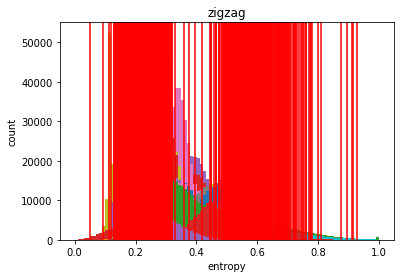

In [7]:
class_array = read_class()
NUM_VALID=80
noise_removal_dataset()